In [ ]:
# Import standard libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Sklearn import
from sklearn.model_selection import train_test_split # Splitting the data set
from sklearn.preprocessing import MinMaxScaler, StandardScaler # Normalization and standard scaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder # Label and 1-hot encoding
from sklearn.linear_model import LogisticRegression # Logistic regression model
from sklearn.neighbors import KNeighborsClassifier # KNN Algorithm
from sklearn.model_selection import GridSearchCV   # Grid search for cross validation
from sklearn.tree import DecisionTreeClassifier, plot_tree # Decision Trees
from sklearn.metrics import accuracy_score  # Accuracy
from sklearn.metrics import confusion_matrix # Confusion matrix
from sklearn.metrics import precision_score, recall_score, f1_score  # Precision, recall, and f1 score

# Classification: K-Nearest Neighbours and Decision Tress

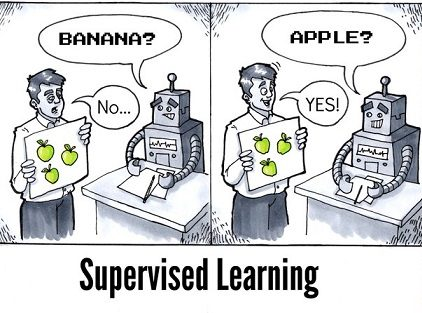


## Content

The goal of this walkthrough is to provide you with insights on classification, focusing on two algorithms: k-Nearest Neighbors and Decision Trees. After presenting the main concepts, you will be introduced to the techniques to implement the algorithms in Python. Finally, it will be your turn to practice, using an application on forest fires. 

This notebook is organized as follows:
- [Background](#Background)
    - [Objective](#Objective)

## K-Nearest Neighbours

<img src='https://miro.medium.com/v2/resize:fit:786/format:webp/0*S4-FHBGgizjGFUjZ.jpg' width="300">

Source: Afroz Chakure, [K-Nearest Neighbors (KNN) Algorithm](https://medium.datadriveninvestor.com/k-nearest-neighbors-knn-algorithm-bd375d14eec7), Published in DataDrivenInvestor

### Background

#### Intuition

The K-Nearest Neighbors (KNN) algorithm assumes that similar things are near to each other: “Birds of a feather flock together”. Following this assumption, in order to classify a point, we measure the distance to the nearest k instances of the training set, and let them vote. K is typically chosen to be an odd number to have a tiebreaker.

<img src='https://miro.medium.com/max/1300/0*Sk18h9op6uK9EpT8.' width="400">

The KNN algorithm is very useful when there are non-linear decision boundaries. For example, consider the image below, displaying whether there is vegetation depending on latitude and longitude. A logistic regression would split our plane into two and thus would not be able to correctly predict that vegetation data points are located in the top right and bottom left quadrants. However, KNN classifiers would perform much better since vegetation (and non-vegetation) data points are grouped in clusters.

<img src='https://miro.medium.com/max/374/1*-W7HOfNfWk5BeXgF5jao6g.png' width="300">

Note that the algorithm can be used for both classification and regression. You can read [The Basics: KNN for classification and regression](https://towardsdatascience.com/the-basics-knn-for-classification-and-regression-c1e8a6c955) for intuition on how KNN can be applied for regression.

#### Distance metric

As mentioned above, the KNN algorithm relies on the notion of distance between observations. Which distance? There are several possibilities, the most popular one being the Euclidean distance:

- [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance), also known as L2 norm. In a plane, it is the shortest distance - . Imagine we have $d$ (real-valued) features and we wish to calculate the distance between two observations $\boldsymbol{x_{1*}}=(x_{11}, ..., x_{1d})$ and $\boldsymbol{x_{2*}}=(x_{21}, ..., x_{2d})$, the Euclidean distance will be:
$$d_2(\boldsymbol{x_{1*}}, \boldsymbol{x_{2*}})= \sqrt{(x_{11}-x_{21})^2 + ... + (x_{1d}-x_{2d})^2 }= \sqrt{\sum_{j=1}^d (x_{1j}-x_{2j})^2}$$
The Euclidean distance is useful in low dimension, it does not work well in high dimensions and for categorical variables. It also ignores the similarity between features since each feature is treated as totally different from all the other features.

- [Manhattan distance](https://en.wikipedia.org/wiki/Taxicab_geometry), also known as L1 norm or "Taxicab". The idea is to travel the space the same way taxis would navigate the streets in a city like the island of Manhattan, known for its [grid plan](https://en.wikipedia.org/wiki/Grid_plan):
$$d_1(\boldsymbol{x_{1*}}, \boldsymbol{x_{2*}})= \sum_{j=1}^d |x_{1j}-x_{2j}|$$
Manhattan distance is favored over Euclidean distance when we have many features (see for instance, Aggarwal, Hinneburg, & Keim paper [On the Surprising Behavior of Distance Metrics in High Dimensional Space](https://link.springer.com/chapter/10.1007/3-540-44503-x_27)).

- [Minkowski distance](https://en.wikipedia.org/wiki/Minkowski_distance) generalizes the Euclidean and Manhattan distance:
$$d_1(\boldsymbol{x_{1*}}, \boldsymbol{x_{2*}})= \left(\sum_{j=1}^d |x_{1j}-x_{2j}|^p \right)^{1/p}$$
For $p=1$, we get the Manhattan distance. For $p=2$, we get the Euclidean distance. For $p$ reaching $\infty$, we have $d_\infty= \min_j |x_{1j}-x_{2j}| $ 

- [Hamming distance](https://en.wikipedia.org/wiki/Hamming_distance) is used to compare distance between strings. It measures the minimum number of substitutions required to change one string into the other, or the minimum number of errors that could have transformed one string into the other. More on that when we will study Text Analytics!

#### What is the right value of k (neighbors)?

We pick the proper k using **cross validation** using ONLY the training data! The test data is used for the final evaluation of our model.

<img src='https://scikit-learn.org/stable/_images/grid_search_cross_validation.png' width="500">

### Implementation

In this walkthrough, we will try to classify fruits based on their characteristics such as mass, width, height, and color. The dataset is available in the /data folder.

In [ ]:
#Load the dataset
url_fruit = 'https://raw.githubusercontent.com/michalis0/MGT-502-Data-Science-and-Machine-Learning/main/data/Fruits.csv'
fruits = pd.read_csv(url_fruit,sep=";")

# Display first 10 observations
display(fruits.head(10))

# Shape of dataset
print('The dataset has {} observations.'.format(fruits.shape[0]))

In [ ]:
list(fruits.fruit_name.unique())

We want to predict the class (`fruit label`) using the features 'mass', 'width', 'height', 'color_score':

In [ ]:
# Define features and target variable
features = ['mass', 'width', 'height', 'color_score']
X = fruits[features]
y = fruits['fruit_label']

Let's check the different fruits in our dataset, the associated label and number of observations:

In [ ]:
fruits.groupby(['fruit_name','fruit_label']).size()

We have balanced class: each fruit has 19 observations.

Finally, let's check the summary statistics of our features:

In [ ]:
X.describe()

Notice that we have quite different scales, e.g., between "mass" and "color_score". We will thus need to rescale our features.

#### Splitting the dataset

As always, the first step is to split our data into random training and test subsets. Recall that the training set is used to learn the parameters of our model while the test set is used to evaluate our predictions.

We use the `train_test_split` ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)) of sklearn, imported with the following line of code (already done at the beginning of the notebook):

```python
from sklearn.model_selection import train_test_split 
```

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

#### Rescaling

When we have a dataset with features that have very distinct ranges, we might get biased results. We want the features to be in the same or similar range, which also helps the interpretation of the model parameters (weights). 

We therefore **normalize** the data. It involves transforming all values for a specific attribute so that they fall within a small specified range. We can use `StandardScaler()`, ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)) `MinMaxScaler()` ([Documentation](https://scikit-learn.org/0.15/modules/generated/sklearn.preprocessing.MinMaxScaler.html)) or others for normalization.

In our example we will normalize both our **train AND test data** using `MinMaxScaler()`. Here is the import line:

```python
from sklearn.preprocessing import MinMaxScaler
```

**IMPORTANT**: When you normalize the train data, you need to do the same modification (here normalization) to the test data. In other words, you train your scaler on your training set, and apply the same transformation to the training and test set.

In [ ]:
# Define the scaler
scaler = MinMaxScaler()

# Fit and transform the training set 
X_train = scaler.fit_transform(X_train)

# Transform the test set
X_test = scaler.transform(X_test)

We can check the results of the normalization process: all values should be between 0 and 1:

In [ ]:
pd.DataFrame(X_train, columns=['mass', 'width', 'height', 'color_score']).describe()

#### Building, training and evaluating our classifier

We implement a KNN algorithm to predict the class of our target variable using the **sklearn** module `KNeighborsClassifier()` ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)). Here is the import line:

```python
from sklearn.neighbors import KNeighborsClassifier
```

We can specify various parameters:
- `n_neighbors`= number of neighboring observations to use
- `p`= determines the distance/similarity metric ("p" refers to the Minkowski distance). 
    - When p = 1, the Manhattan distance (l1-norm) is used, 
    - When p = 2 (default value), the Euclidean_distance (l2-norm) is used. 
- `weights`= determines how to weigh the neighboring observations. 
  - When set to `uniform` (default value): uniform weights. All points in each neighborhood are weighted equally. 
  - When set to `distance` : weight points by the inverse of their distance. In this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.

Please refer to the documentation for the full list of parameters.

We will start by arbitrarily selecting k=7 neighbors, and default values for the other parameters.

In [ ]:
# Set up our model
model_kNN = KNeighborsClassifier(n_neighbors=7, p=2, weights='uniform')

# Fit our model
model_kNN.fit(X_train, y_train)

Let's check the accuracy of our classifier:

In [ ]:
print('Accuracy of KNN classifier on test set: {:.2f}'.format(model_kNN.score(X_test, y_test)))

print('Accuracy of KNN classifier on training set: {:.2f}'.format(model_kNN.score(X_train, y_train)))

Not bad! 

Let's loop over the model parameters (number of neighbors, distance metric, weights) to check how the accuracy is affected:

In [ ]:
n_neighbors = [1,3,5,7]
p_values = [1,2,3]
weights = ['uniform', 'distance']

for w in weights:
    for p in p_values:
        for n in n_neighbors:
            model = KNeighborsClassifier(n_neighbors=n, p=p, weights=w)
            model.fit(X_train, y_train)
            acc_model = model.score(X_test, y_test)
            print(f"Accuracy of KNN classifier for k = {n}, p = {p}, weight = {w}: {acc_model:0.2f}")

The accuracy is higher when we add weights based on the distance. The performance of the distance metrics depends on the number of neighbors selected. Interestingly, the best accuracy seems to be obtained using 3 or 5 neighbors, but then decrease, maybe due to the limited amount of observations in our dataset. In the following, we will use cross-validation to find the "optimal" parameters.

#### Tuning parameters with cross-validation

We now want to find which parameters of our KNN algorithm are the optimal ones. We use Grid Search Cross Validation, the idea being to explore a grid of potential parameters. 

The associated sklearn module is `GridSearchCV()` ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)), imported via the following line code:

```python
from sklearn.model_selection import GridSearchCV 
```

As parameters, we need to provide our `estimator`, i.e., our model, and a grid of parameters. We can also specify the number of folds `cv` used for cross-validation. Let's try!

In [ ]:
# Define parameters to test
grid = {'n_neighbors':np.arange(1,10),     # array from 1 to 10 neighbors
        'p':np.arange(1,3),                # array from 1 to 3, distance metrics
        'weights':['uniform','distance']   # weights
       }

# Define and fit model
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, grid, cv=7)
knn_cv.fit(X_train, y_train)

# Print results
print("Hyperparameters:", knn_cv.best_params_)
print("Train Score: {:0.2f}".format(knn_cv.best_score_))
print("Test Score: {:0.2f}".format(knn_cv.score(X_test, y_test)))

No need for a complex model, only one neighbor and we get a perfect accuracy!

## Decision Trees

<img src='https://regenerativetoday.com/wp-content/uploads/2022/04/dt.png' width="400">

Source: [Simple Explanation on How Decision Tree Algorithm Makes Decisions](https://regenerativetoday.com/simple-explanation-on-how-decision-tree-algorithm-makes-decisions/)

### Background

#### Intuition

Decision trees, as the name goes, use a tree-like model of decisions. At each node, the algorithm chooses a splitting rule (based on a feature) that maximizes the accuracy of the model. More precisely, at every split the algorithm maximizes a certain criterion previously given (e.g., Gini index, information gain). 

The objective of the algorithm is to find the simplest possible decision tree (i.e., only a few nodes = a small depth) with the highest accuracy. 

Consider the example below, where the objective is to classify if a person is fit or not. If we would have chosen another criterion for the root node (e.g., "Exercises in the morning" intead of "Age<30"), we could have ended up with a lower accuracy and/or more splits (i.e., a more complex tree). The same logic applies at each decision node, until we reach the leafs, i.e., the final decision.

<img src='https://cdn.educba.com/academy/wp-content/uploads/2019/05/is-a-person-fit.png' width="300">

Decision Trees are simple to understand, interpret, and visualize. They can handle both numerical and categorical data, they do not require feature scaling and can deal with outliers. The algorithm is also good at at handling non-linearly separable data. 

As a drawback, Decision Trees suffer for a risk of overfitting, especially with large dataset since the tree might become too complex. They can also be unstable because small variations in the data might result in a completely different tree being generated. Potential solutions to avoid overfitting and get better performance include:
- Rely on cross-validation to find the proper depth.
- Building a collection of trees, i.e., a Random Forest - you can for instance read [Understanding Random Forest](https://towardsdatascience.com/understanding-random-forest-58381e0602d2) for more explanation on the topic.

Finally, note that, as for KNN, Decision Trees can be used for both classification and regression. You can read [Machine Learning Basics: Decision Tree Regression](https://towardsdatascience.com/machine-learning-basics-decision-tree-regression-1d73ea003fda) for a walk through on how to apply Decision Tree for regression tasks.

#### Decision criteria

Growing a tree involves deciding on which features to choose and what conditions to use for splitting, along with knowing when to stop. How to do so? We need decision criteria, which evaluate the cost of a split, or alternatively, the "purity" of the selection. Here are some measures:

- [Information Gain](https://en.wikipedia.org/wiki/Information_gain_(decision_tree)) measures... the information gained thanks to the split, relying on the notion of [Entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory)):
$$\text{Entropy}= - \sum_{i=1}^c p_i \log_2(p_i)$$
where $c$ is the number of class and $p_i$ is the probability of randomly selecting an observation in class $i$. Let's consider two classes "0" and "1" for simplicity: $\text{Entropy} = - p_0 \log_2(p_0) - p_1 \log_2(p_1)$:
    - When our dataset (or node) has 50% of observations belonging to class "0" and 50% belonging to class "1", then $p_0=p_1=1/2$ and $\text{Entropy} = 1$.
    - When our dataset (or node) is "pure", say 0% of observations belonging to class "0" and 100% to class "1", then $p_0=0$, $p_1=1$, and $\text{Entropy} = 0$

<center>
<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/2/22/Binary_entropy_plot.svg/800px-Binary_entropy_plot.svg.png' width="300">
</center>

Source: Brona, Wikipedia [Binary entropy plot](https://commons.wikimedia.org/wiki/File:Binary_entropy_plot.svg)

At each decision node, we compute the associated Entropy. This allows to calculate the information gain:
$$\text{Information Gain}=\text{Entropy}_\text{parent}-\text{Average Entropy}_\text{children}$$

Our objective is to obtain pure leaf nodes, and thus to reduce the entropy in the children nodes. Say differently, we need to find the splits that maximize the Information Gain.

- Gini Index, also called [Gini Impurity](https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity), is an alternative decision criterion, inspired by the [Gini coefficient](https://en.wikipedia.org/wiki/Gini_coefficient), a measure intended to represent the wealth inequality within a nation or a social group. The Gini of a dataset is:
$$\text{Gini}=1-\sum_{i=1}^c p_i^2$$
Let's again consider two classes for simplicity "0" and "1", $\text{Gini}=1-p_0^2-p_1^2$
    - When our dataset (or node) has 50% of observations belonging to class "0" and 50% belonging to class "1", then $p_0=p_1=1/2$ and $\text{Gini} = 0.5$.
    - When our dataset (or node) is "pure", say 0% of observations belonging to class "0" and 100% to class "1", then $p_0=0$, $p_1=1$, and $\text{Gini} = 0$

At each decision node we compute the associated Gini Index, and then the average Gini Index of the split. Our objective is to minimize the Gini Index.

For further information on the topic, you can read the articles: 
- [Decision Trees Explained — Entropy, Information Gain, Gini Index, CCP Pruning](https://towardsdatascience.com/decision-trees-explained-entropy-information-gain-gini-index-ccp-pruning-4d78070db36c)
- [Understanding the Gini Index and Information Gain in Decision Trees](https://medium.com/analytics-steps/understanding-the-gini-index-and-information-gain-in-decision-trees-ab4720518ba8)

### Implementation

We will use the same dataset, trying to predict the type of fruits based on the same features. We are using the same training and test set for comparability between model.

#### Building, training, and evaluating our classifier

We implement a Decision Tree algorithm to predict the class of our target variable using the **sklearn** module `DecisionTreeClassifier()` ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)). Here is the import line:

```python
from sklearn.tree import DecisionTreeClassifier
```

We can specify various parameters:
- `criterion`= determines how to measure the quality of a split: "gini" for Gini Impurity (default value), "entropy or "log_loss" for Information Gain
- `max_depth`= determines the depth of the tree, i.e., the amount of nodes we allow the tree to generate. If None (default value), then nodes are expanded until all leaves are pure or until all leaves contain less than a given number of samples.

Please refer to the documentation for the full list of parameters.

We will start by arbitrarily selecting a maximum depth of 5, and default values for the other parameters.

In [ ]:
# Create model 
model_tree = DecisionTreeClassifier(criterion = 'gini', max_depth = 5)

# Fit model
model_tree.fit(X_train, y_train)

# Test accuracy
print('Accuracy of Decision Tree on test set: {:.2f}'.format(model_tree.score(X_test, y_test)))
print('Accuracy of Decision Tree on training set: {:.2f}'.format(model_tree.score(X_train, y_train)))

We achieve perfection on the test set, but our model may be overly complicated. Let's see if we can reduce max depth without losing accuracy by using cross validation.

#### Tuning parameters with cross-validation

We proceed as previously for the KNN algorithm, using Grid Search Cross Validation. 

The associated sklearn module is `GridSearchCV()`.

In [ ]:
# Define parameters to test
grid_tree = {'criterion':['gini','entropy'] ,     # criterion
        'max_depth':np.arange(1,5),               # array from 1 to 5, maximum depth
       }

# Define and fit model
dec_tree = DecisionTreeClassifier()
dec_tree_cv = GridSearchCV(dec_tree, grid_tree, cv=5)
dec_tree_cv.fit(X_train, y_train)

# Print results
print("Hyperparameters:", dec_tree_cv.best_params_)
print("Best model:", dec_tree_cv.best_estimator_)
print("Train Score: {:0.2f}".format(dec_tree_cv.best_score_))
print("Test Score: {:0.2f}".format(dec_tree_cv.score(X_test, y_test)))

We could reduce the depth to 2 and still got a perfect accuracy on the test set. However, we should remember that we have a limited number of observations so the results should be understood with a grain of salt.

#### Visualize tree

We can visualize our Decision Tree, allowing us to get a better understanding of the decisions made by our algorithm and of the features that played a key role in our classification.

To do so, we are using the `plot_tree()` module of sklear ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html)). Here is the import line:

```python
from sklearn.tree import plot_tree
```

We plot our first model.

In [ ]:
plt.figure(figsize=(7,7))
plot_tree(model_tree, filled=True, feature_names=('mass', 'width', 'height', 'color_score'), fontsize=12)
plt.show()

Our tree starts with the root in which we have 38 samples (our data points), 19 belonging to class 1 and 19 belonging to class 2.

Each node represents a condition on which the tree splits into branches. For instance, the first two depth levels are using the "color_score" as feature to split, and the last node is using the mass. 

The end of a branch that no longer splits is a leaf. Here we have perfectly classified our observations. 

The colors represent the purity of a node. In our case, blue corresponds to class 1 (apples) and orange corresponds to class 2 (oranges). They are displayed because we specified the parameter `filled = True`.

Finally, the gini coefficient is our measure of purity for each node. In our dataset we start with 0.5 (corresponds to the 50-50 distribution of classes in the root) and then gradually go down to 0 (maximum purity).

## Your turn


Now it's your turn to implement a classifier! We will try to improve the accuracy we obtained last week when we implemented a logistic regression classifier to predict whether a forest fire spread and burned forest areas in the Montesinho natural park in Portugal.

We are using the [Forest Fires dataset](https://www.kaggle.com/datasets/sumitm004/forest-fire-area), created by Paulo Cortez and Aníbal Morais, and available on Kaggle.

Source: P. Cortez and A. Morais. A Data Mining Approach to Predict Forest Fires using Meteorological Data. In J. Neves, M. F. Santos and J. Machado Eds., New Trends in Artificial Intelligence, Proceedings of the 13th EPIA 2007 - Portuguese Conference on Artificial Intelligence, December, Guimaraes, Portugal, pp. 512-523, 2007. APPIA, ISBN-13 978-989-95618-0-9.

The original dataset contains 13 columns:
- X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
- Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
- month - month of the year: "jan" to "dec" 
- day - day of the week: "mon" to "sun"
- FFMC - Fine Fuel Moisture Code (FFMC) index from the [Fire Weather Index (FWI)](https://www.nwcg.gov/publications/pms437/cffdrs/fire-weather-index-system) system: 18.7 to 96.20
- DMC - Duff Moisture Code (DMC) index from the FWI system: 1.1 to 291.3 
- DC - Drought Code (DC) index from the FWI system: 7.9 to 860.6 
- ISI - Initial Spread Index (ISI) index from the FWI system: 0.0 to 56.10
- temp - temperature in Celsius degrees: 2.2 to 33.30
- RH - relative humidity in %: 15.0 to 100
- wind - wind speed in km/h: 0.40 to 9.40 
- rain - outside rain in mm/m2 : 0.0 to 6.4 
- area - the burned area of the forest (in ha): 0.00 to 1090.84

In addition, we created a new column, "class", detailing whether the fire burned an area of forest:
- class is equal to 0 if area = 0.00 ha
- class is equal to 1 if area > 0.00 ha 

Our goal will be to predict the class using KNN algorithm and Decision Tree, given the weather and FWI features.

Let's pick up where we left off last week, with a rescaled training and test set:

In [ ]:
# Load data
url_ff = 'https://raw.githubusercontent.com/michalis0/MGT-502-Data-Science-and-Machine-Learning/main/data/forestfires.csv'
forest_fire = pd.read_csv(url_ff)

# Extract features and class
X_forest = forest_fire[['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']]
y_forest = forest_fire['class'] 

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_forest, y_forest, 
                                                            test_size=0.2, 
                                                            random_state=19, 
                                                            shuffle=True)

# Rescaling
scaler = MinMaxScaler() # Define the scaler
scaler.fit(X_train)   # Fit the scaler
# Transform the train and the test set
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Here is what we obtained with a Logistic Regression:

In [ ]:
# Set up our model
model_log = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000)

# Fit our model
model_log.fit(X_train, y_train)

# Accuracy
print('Accuracy of classifier on test set: {:.2f}'
     .format(model_log.score(X_test, y_test)))
print('Accuracy of classifier on training set: {:.2f}'
     .format(model_log.score(X_train, y_train)))

# Confusion matrix
sns.heatmap(confusion_matrix(y_test, model_log.predict(X_test)), annot=True, cmap='Blues', fmt='.4g')
plt.xlabel('Predicted label')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

- Build and train a KNN classifier with 5 neighbors

In [ ]:
# YOUR CODE HERE


- Compare the training and testing accuracy of your model, and create a heatmap of the confusion matrix. What do you think?

In [ ]:
# YOUR CODE HERE


- Explore a grid a parameters with `GridSearchCV`, using 7 folds. Check the accuracy on the training and test set.

In [ ]:
# YOUR CODE HERE


- Build and train a Decision Tree Classifier with a maximum depth of 7.

In [ ]:
# YOUR CODE HERE


- Compare the accuracy on the training set and the test set, and create a heatmap of your confusion matrix

In [ ]:
# YOUR CODE HERE


- Explore with `GridSearchCV` a grid of parameters. Check the accuracy on the training and test set.

In [ ]:
# YOUR CODE HERE
